# 네이버 영화리뷰 분석

### 1) 라이브러리 임포트

In [1]:
!pip install gensim==3.8.3

In [2]:
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.initializers import Constant

from konlpy.tag import Mecab

from collections import Counter

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

In [3]:
# 랜덤 시드 설정
tf.random.set_seed(36)
np.random.seed(36)

### 2) 필수 함수 정의

In [4]:
def history_plot(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()   # 그림을 초기화합니다
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 네이버 리뷰 데이터 로드

In [5]:
root_path = '~/aiffel/sentiment_classification/data'
train_data = pd.read_table(root_path + '/ratings_train.txt')
test_data = pd.read_table(root_path + '/ratings_test.txt')

# 의미없는 자-모 형태, 기타기호 모두 제거
train_data['document'] = train_data['document'].str.replace(r'[^가-힣\s]', ' ', regex=True)
test_data['document'] = test_data['document'].str.replace(r'[^가-힣\s]', ' ', regex=True)

train_data.head(10)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화 별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


### 4) 문자 토큰화, train/test 데이터 분리

In [28]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를',
             '으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for idx, sentence in enumerate(train_data['document']):
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if word not in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for idx, sentence in enumerate(test_data['document']):
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if word not in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return (
        X_train,
        np.array(list(train_data['label'])),
        X_test,
        np.array(list(test_data['label'])),
        word_to_index
    )

# 각 사전크기별로 모델 돌릴때마다 전처리가 너무 느려서 딕셔너리에 저장해둠
import time
start_time = time.time()
train_set = {}
for num in [10000, 20000, 30000]:
    train_set[num] = load_data(
        train_data, test_data, num_words=num
    )
print(f'elapsed time: {(time.time() - start_time):.4f}')

X_train, y_train, X_test, y_test, word_to_index = train_set[10000]
print("X_train size:", len(X_train))
print("y_train size:", len(y_train))
print("X_test size:", len(X_test))
print("y_test size:", len(y_test))

index_to_word = {index: word for word, index in word_to_index.items()}
print("words:", len(index_to_word))

elapsed time: 57.7958
X_train size: 144809
y_train size: 144809
X_test size: 48719
y_test size: 48719
words: 10000


### 5) 전처리 데이터 index to word 확인

In [7]:
for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[27, 65, 868, 33, 208, 15, 28, 688]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[958, 472, 482, 630, 4, 108, 1537, 47, 858, 935, 11, 39, 354]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 187, 2]
재 <UNK>
라벨:  0
[8007, 140, 4035, 270, 83, 13, 5, 51, 3306]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8462, 1035, 47, 2682, 53, 4, 2610, 34, 1106, 29, 317, 36, 17, 35, 53, 2, 2, 385, 2903, 1657, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1


In [8]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = X_train + X_test
num_tokens = np.array([len(tokens) for tokens in total_data_text])

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 최대 길이를 (평균 + 2 * 표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen :', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) *100}%가 maxlen 설정값 이내에 포함됩니다.')


문장길이 평균 : 13.671396387086107
문장길이 최대 : 83
문장길이 표준편차 : 11.423903184065953
pad_sequences maxlen : 36
전체 문장의 93.43092472407093%가 maxlen 설정값 이내에 포함됩니다.


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index['<PAD>'],
                                       padding='pre',
                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index['<PAD>'],
                                       padding='pre',
                                       maxlen=maxlen)

print(X_train.shape)

(144809, 36)


In [10]:
# 훈련용 데이터셋 146,182건 중 40,000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("partial_x_train:", partial_x_train.shape)
print("partial_y_train:", partial_y_train.shape)

x_val: (40000, 36)
y_val: (40000,)
partial_x_train: (104809, 36)
partial_y_train: (104809,)


## 모델 트레이닝

### 1. LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 36)          360000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               300032    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 662,097
Trainable params: 662,097
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6551/6551 [==============================] - 39s 6ms/step - loss: 0.3885 - accuracy: 0.8234 - val_loss: 0.3461 - val_accuracy: 0.8470
Epoch 2/3
6551/6551 [==============================] - 37s 6ms/step - loss: 0.3070 - accuracy: 0.

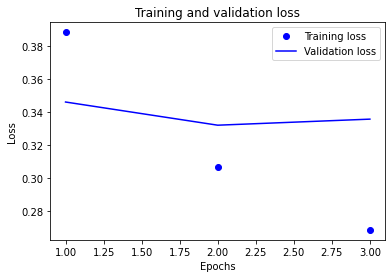

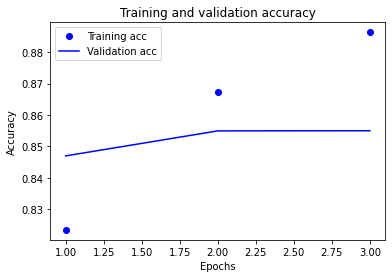

1523/1523 - 4s - loss: 0.3389 - accuracy: 0.8517
LSTM: 85.1742%, loss: 33.8910%


In [13]:
vocab_size = 10000
word_vector_dim = 36

# LSTM 레이어로 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 3  # epochs 3회 이후부터 정확도 하락

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=16,
                   validation_data=(x_val, y_val),
                   verbose=1)

history_plot(history)

results = model.evaluate(X_test, y_test, verbose=2)
print(f'LSTM: {results[1]*100:.4f}%, loss: {results[0]*100:.4f}%')

> Epoch 3회 이후부터 정확도가 하락한다.
>
> LSTM 정확도 85.17%

### 2. 1-D CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 36)          360000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1744      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

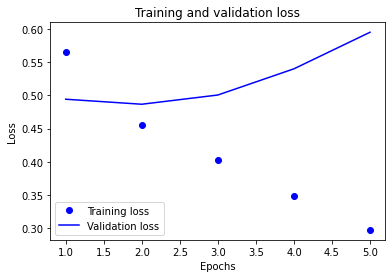

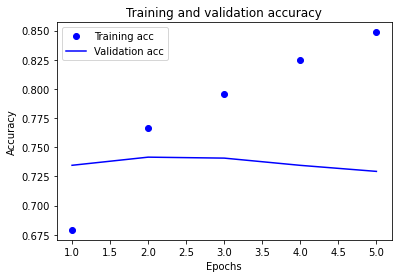

1523/1523 - 2s - loss: 0.6023 - accuracy: 0.7231
1-D CNN: 72.3085%, loss: 60.2326%


In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 36  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(x_val, y_val),
                   verbose=1)

history_plot(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print(f'1-D CNN: {results[1]*100:.4f}%, loss: {results[0]*100:.4f}%')

> Epoch 10회로 늘려도 정확도가 올라갈 기미가 없다..
>
> 1-D CNN 정확도 72.3%

### 3. GlobalMaxPooling1D

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
410/410 [==============================] - 2s 4ms/step - loss: 0.5464 - accuracy: 0.7438 - val_loss: 0.4019 - val_accuracy: 0.8205
Epoch 2/5
410/410 [==============================] - 1s 4ms/step - loss: 0.3715 - accuracy: 0.8387 -

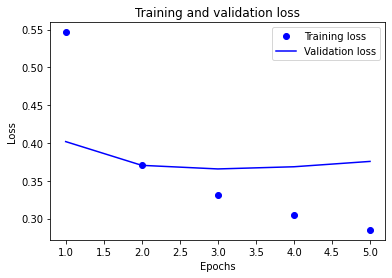

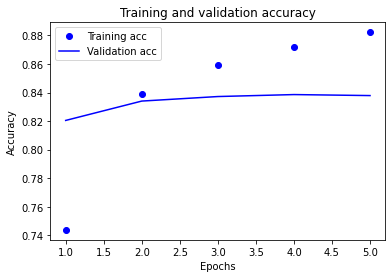

1523/1523 - 2s - loss: 0.3847 - accuracy: 0.8343
GlobalMaxPooling1D: 83.4274%, loss: 38.4688%


In [17]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

print(model.summary())

# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(x_val, y_val),
                   verbose=1)

history_plot(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print(f'GlobalMaxPooling1D: {results[1]*100:.4f}%, loss: {results[0]*100:.4f}%')

> 1-D CNN 방식보단 효과적이다
>
> GlobalMaxPooling1D 정확도 83.42%

### 4. word2vec & LSTM

In [18]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
print(word2vec)
word2vec.wv.most_similar("사랑")

Word2Vec(vocab=30185, size=200, alpha=0.025)


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [31]:
# 반복 테스트를 위한 word2vec 트레이닝 함수화
def word2vec_test(vocab_size=10000, epochs=3):
    word_vector_dim = 200

    X_train, y_train, X_test, y_test, word_to_index = train_set[vocab_size]
    index_to_word = {index:word for word, index in word_to_index.items()}

    total_data_text = X_train + X_test
    num_tokens = np.array([len(tokens) for tokens in total_data_text])
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)

    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                           value=word_to_index['<PAD>'],
                                           padding='pre',
                                           maxlen=maxlen)

    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                           value=word_to_index['<PAD>'],
                                           padding='pre',
                                           maxlen=maxlen)

    x_val2 = X_train[:40000]
    y_val2 = y_train[:40000]

    partial_x_train = X_train[40000:]
    partial_y_train = y_train[40000:]

    embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

    for i in range(4, vocab_size):
        if index_to_word[i] in word2vec:
            embedding_matrix[i] = word2vec[index_to_word[i]]

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=maxlen, 
                                     trainable=True))

    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=64,
                        validation_data=(x_val, y_val),
                        verbose=1)

    history_plot(history)

    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'Word2vec LSTM(사전크기 {vocab_size}): {results[1]*100:.4f}%, loss: {results[0]*100:.4f}%')

### 4-1. word2vec 사전크기: 10,000

/tmp/ipykernel_5234/2300581034.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5234/2300581034.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1638/1638 [==============================] - 13s 7ms/step - loss: 0.4051 - accuracy: 0.8119 - val_loss: 0.3332 - val_accuracy: 0.8544
Epoch 2/2
1638/1638 [==============================] - 11s 7ms/step - loss: 0.2982 - accuracy: 0.8

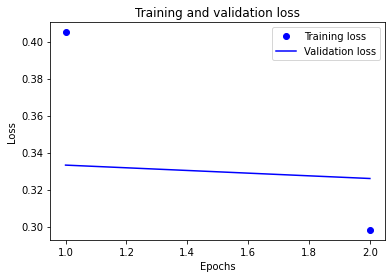

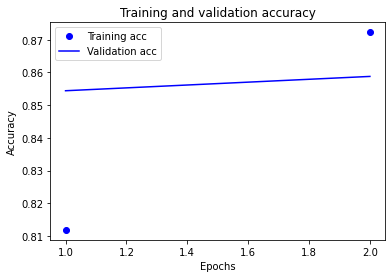

1523/1523 - 4s - loss: 0.3312 - accuracy: 0.8557
Word2vec LSTM(사전크기 10000): 85.5683%, loss: 33.1233%


In [24]:
word2vec_test(vocab_size=10000, epochs=2)

> 일반 LSTM보단 소폭 상승했다.
>
> Word2vec LSTM(사전크기 10000): 85.56%

### 4-2. word2vec 사전크기: 20,000

/tmp/ipykernel_5234/2300581034.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5234/2300581034.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 36, 200)           4000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 4,470,033
Trainable params: 4,470,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1638/1638 [==============================] - 15s 9ms/step - loss: 0.4052 - accuracy: 0.8128 - val_loss: 0.3332 - val_accuracy: 0.8540
Epoch 2/3
1638/1638 [==============================] - 13s 8ms/step - loss: 0.2911 - accuracy: 0.

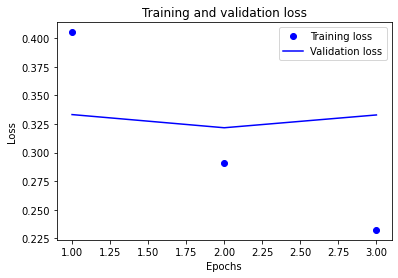

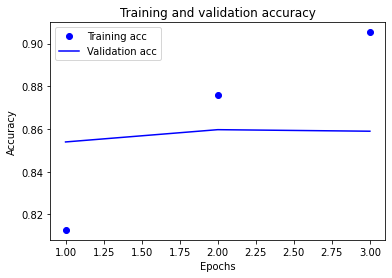

1523/1523 - 4s - loss: 0.3388 - accuracy: 0.8577
Word2vec LSTM(사전크기 20000): 85.7735%, loss: 33.8816%


In [27]:
word2vec_test(vocab_size=20000, epochs=3)

> 사전수를 두배로 늘리니 소폭 상승했다.
>
> Word2vec LSTM(사전크기 20,000): 85.77%

### 4-1. word2vec 사전크기: 30,000

/tmp/ipykernel_5234/2300581034.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5234/2300581034.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 36, 200)           6000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               467968    
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 6,470,033
Trainable params: 6,470,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1638/1638 [==============================] - 16s 9ms/step - loss: 0.4058 - accuracy: 0.8118 - val_loss: 0.3321 - val_accuracy: 0.8561
Epoch 2/2
1638/1638 [==============================] - 14s 9ms/step - loss: 0.2858 - accuracy: 0.

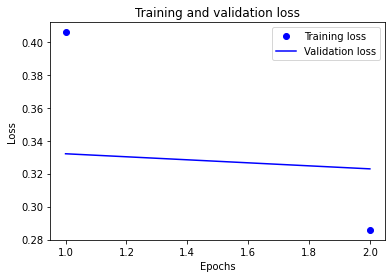

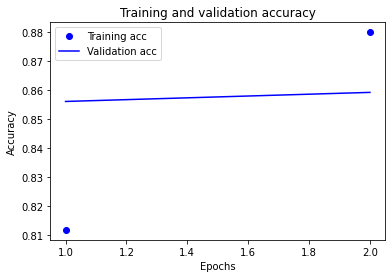

1523/1523 - 4s - loss: 0.3277 - accuracy: 0.8585
Word2vec LSTM(사전크기 30000): 85.8515%, loss: 32.7717%


In [30]:
word2vec_test(vocab_size=30000, epochs=2)

> 사전수를 두배로 늘리니 소폭 상승했다.
>
> Word2vec LSTM(사전크기 30,000): 85.85%

## 회고

* LSTM 방식이 훈련결과가 가장 좋았다.
    1. word2vec LSTM(사전크기 30,000): 85.85%
    2. word2vec LSTM(사전크기 20,000): 85.77%
    3. word2vec LSTM(사전크기 10,000): 85.56%
    4. LSTM(사전크기 10,000): 85.17%
* word2vec 을 적용하고 사전크기를 늘릴수록 정확도가 소폭 상승했다.
* Mecab으로 명사+동사만 추출해 시도했을 땐 50% 언저리를 벗어나지 못했다.
* 형태소 정리를 잘 하고, 적절한 사전크기와 그에 맞는 하이퍼파라미터 튜닝으로 85% 이상을 달성해보고 싶다.